In [1]:
# Place your data and annotation directories here 
annotation_dir = "/home/rex/datasets/coco2017/annotations/"
annotation_file = annotation_dir + "person_keypoints_val2017.json"
data_dir = "/home/rex/datasets/coco2017/val2017/"

In [2]:
import json
with open(annotation_file, "r") as a_file:
    data = json.load(a_file)

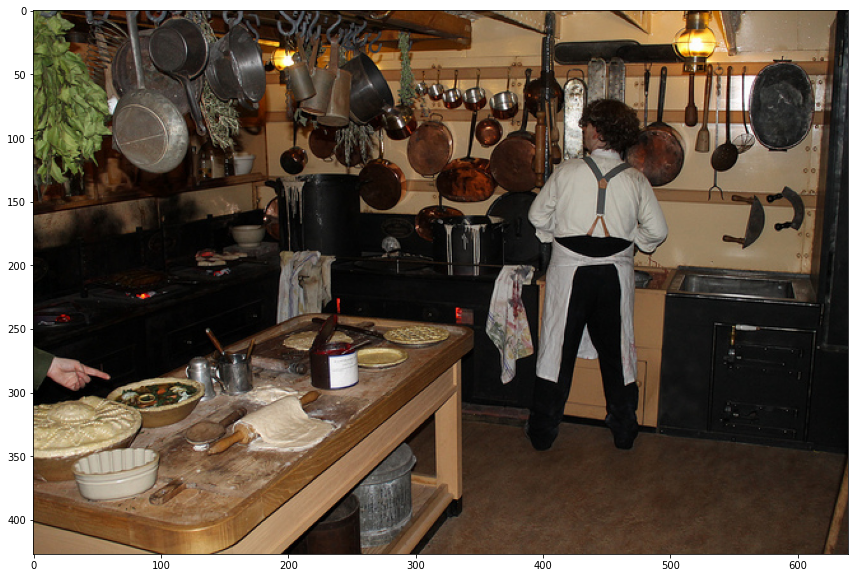

In [3]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 10)
import cv2


img = cv2.imread(data_dir +  data['images'][0]['file_name'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [4]:
def keypoints2xy(keypoints_arr):
    keypoints = []
    for i in range(0, len(keypoints_arr), 3):
        if keypoints_arr[i+2] == 2:
            keypoints.append((keypoints_arr[i], keypoints_arr[i+1]))
        else:
            keypoints.append((-1, -1))
            
    return keypoints

In [5]:
def draw_artifacts(img, plottable_kp, new_bbox):
    cropped_img = img[new_bbox[0][1]: new_bbox[1][1], new_bbox[0][0]: new_bbox[1][0]] # (y, x)
    cv2.rectangle(img, new_bbox[0], new_bbox[1], (255,0,0), 2)
    for idx in range(len(plottable_kp)-1):
        cv2.circle(img, plottable_kp[idx], color=(255, 0, 0), radius=1)
    plt.imshow(img)

In [ ]:
processed_annotaion = []

print(f"Processing {len(data['images'])} files...")

for idx, elem in enumerate(data['images']):  
    if idx % 1000 == 0:
        print(f"Processed {idx} files")

    img = cv2.imread(data_dir + elem['file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    elem_annotation = list(filter(lambda x: x['image_id'] == elem['id'], data['annotations']))

    for _annot in elem_annotation:
        new_anno_elem = {}
        
        if _annot['num_keypoints'] <= 10 or _annot['category_id'] != 1:
            continue 
            
        plottable_kp = keypoints2xy(_annot['keypoints']) 
            
        new_anno_elem['file_name'] = data_dir + elem['file_name']
        
        
        bbox = _annot['bbox']
        x, y, w, h = bbox

        x_scale = w/64
        y_scale = h/64

        h_con, w_con = 0, 0 #int(h/1), int(w/1)
        new_bbox = [(int(max(0, x - h_con)), int(max(0, y - h_con))), (int(min(x + w + w_con, elem['width'])), int(min(elem['height'], y + h + h_con)))]
    

        new_anno_elem['bbox'] = new_bbox
        new_anno_elem['keypoints'] = []
        
        cropped_img = img[new_bbox[0][1]: new_bbox[1][1], new_bbox[0][0]: new_bbox[1][0]] # (y, x)


        for idx in range(len(plottable_kp)):
            prev_pt = plottable_kp[idx]
            if prev_pt[0] < 0:
                new_anno_elem['keypoints'].append(prev_pt)
                continue              
            else:                
                new_pt = (int((prev_pt[0] - bbox[0]) / x_scale), int((prev_pt[1] - bbox[1]) / y_scale))
                new_anno_elem['keypoints'].append(new_pt)

        if len(new_anno_elem) > 0:
            processed_annotaion.append(new_anno_elem)
    

Processing 5000 files...
Processed 0 files
Processed 1000 files


In [ ]:
with open(annotation_dir + "person_keypoints_val2017_single_person_all_tmp.json", "w") as json_file:
    json.dump(processed_annotaion, json_file)

In [ ]:
with open(annotation_dir + "person_keypoints_val2017_single_person_all_tmp.json", "r") as json_file:
    data2 = json.load(json_file)

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
for elem in data2[:20]:
    img_file = elem['file_name']
    img = cv2.imread(img_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cropped_img = img[elem['bbox'][0][1]: elem['bbox'][1][1], elem['bbox'][0][0]: elem['bbox'][1][0]]
    cropped_img = cv2.resize(cropped_img, (64, 64))
    
    for pt in elem['keypoints']:
        cv2.circle(cropped_img, tuple(pt), color=(0, 255, 255), radius=1)
    
    
    plt.imshow(cropped_img)
    plt.show()